In [1]:
# example of pix2pix gan for satellite to map image-to-image translation
import numpy as np
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img,save_img
from keras.utils.vis_utils import plot_model

# define the discriminator model
def define_discriminator(image_shape):
        # weight initialization
        init = RandomNormal(stddev=0.02)
        # source image input
        in_src_image = Input(shape=image_shape)
        # target image input
        in_target_image = Input(shape=image_shape)
        # concatenate images channel-wise
        merged = Concatenate()([in_src_image, in_target_image])
        # C64
        d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
        d = LeakyReLU(alpha=0.2)(d)
        # C128
        d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        # C256
        d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        # C512
        d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        # second last output layer
        d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        # patch output
        d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
        patch_out = Activation('sigmoid')(d)
        # define model
        model = Model([in_src_image, in_target_image], patch_out)
        # compile model
        opt = Adam(learning_rate=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
        return model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
        # weight initialization
        init = RandomNormal(stddev=0.02)
        # add downsampling layer
        g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
        # conditionally add batch normalization
        if batchnorm:
            g = BatchNormalization()(g, training=True)
        # leaky relu activation
        g = LeakyReLU(alpha=0.2)(g)
        return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
        # weight initialization
        init = RandomNormal(stddev=0.02)
        # add upsampling layer
        g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
        # add batch normalization
        g = BatchNormalization()(g, training=True)
        # conditionally add dropout
        if dropout:
            g = Dropout(0.5)(g, training=True)
        # merge with skip connection
        g = Concatenate()([g, skip_in])
        # relu activation
        g = Activation('relu')(g)
        return g

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
        # weight initialization
        init = RandomNormal(stddev=0.02)
        # image input
        in_image = Input(shape=image_shape)
        # encoder model
        e1 = define_encoder_block(in_image, 64, batchnorm=False)
        e2 = define_encoder_block(e1, 128)
        e3 = define_encoder_block(e2, 256)
        e4 = define_encoder_block(e3, 512)
        e5 = define_encoder_block(e4, 512)
        e6 = define_encoder_block(e5, 512)
        e7 = define_encoder_block(e6, 512)
        # bottleneck, no batch norm and relu
        b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
        b = Activation('relu')(b)
        # decoder model
        d1 = decoder_block(b, e7, 512)
        d2 = decoder_block(d1, e6, 512)
        d3 = decoder_block(d2, e5, 512)
        d4 = decoder_block(d3, e4, 512, dropout=False)
        d5 = decoder_block(d4, e3, 256, dropout=False)
        d6 = decoder_block(d5, e2, 128, dropout=False)
        d7 = decoder_block(d6, e1, 64, dropout=False)
        # output
        g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
        out_image = Activation('tanh')(g)
        # define model
        model = Model(in_image, out_image)
        opt = Adam(learning_rate=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
        plot_model(model, to_file='generator_model_plot.png', show_shapes=True, show_layer_names=True)
        return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
        # make weights in the discriminator not trainable
        for layer in d_model.layers:
            if not isinstance(layer, BatchNormalization):
                  layer.trainable = False
        # define the source image
        in_src = Input(shape=image_shape)
        # connect the source image to the generator input
        gen_out = g_model(in_src)
        # connect the source input and generator output to the discriminator input
        dis_out = d_model([in_src, gen_out])
        # src image as input, generated image and classification output
        model = Model(in_src, [dis_out, gen_out])
        # compile model
        opt = Adam(learning_rate=0.0002, beta_1=0.5)
        model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
        return model

# load and prepare training images
def load_real_samples(filename):
        # load compressed arrays
        data = load(filename)
        # unpack arrays
        X1, X2 = data['arr_0'], data['arr_1']
        return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
        # unpack dataset
        trainA, trainB = dataset
        # choose random instances
        ix = randint(0, trainA.shape[0], n_samples)
        X1=[]
        X2=[]
        for i in ix:
            pixels = load_img(trainA[i], target_size=(256,256,3))
            src = img_to_array(pixels)
            X1.append(src)
            pixels = load_img(trainB[i], target_size=(256,256,3))
            tgt = img_to_array(pixels)
            X2.append(tgt)
        X1=np.array(X1)
        X1 = (X1 - 127.5) / 127.5
        X2=np.array(X2)
        X2 = (X2 - 127.5) / 127.5
        # generate 'real' class labels (1)
        y = ones((n_samples, patch_shape, patch_shape, 1))
        return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')
        pyplot.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
        pyplot.axis('off')
        pyplot.imshow(X_realB[i])
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'model_%06d.h5' % (step+1)
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    if n_steps>1000:
        n_steps=1000
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # summarize model performance
        if (i+1) % 100 == 0:
              summarize_performance(i, g_model, dataset)
    g_model.save_weights ('C:/projets/oktal-se/g_model.h5')
    return(d_model, g_model)

# load image data
filename = 'C:/projets/oktal-se/entropy_256.npz'
dataset = load_real_samples(filename)
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
pixels = load_img(dataset[0][0], target_size=(256,256,3))
# convert to numpy array
tgt = img_to_array(pixels)
print(tgt.shape)
image_shape = tgt.shape
# define the models

d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)
g_model.summary()
'''
#load weights
print("d_model")
d_model.load_weights ('C:/projets/oktal-se/d_model.h5')
print("g_model")
g_model.load_weights ('C:/projets/oktal-se/g_model.h5')
print("gan_model")
gan_model.load_weights ('C:/projets/oktal-se/gan_model.h5')

# train model
(d_model, g_model)=train(d_model, g_model, gan_model, dataset,n_epochs=100, n_batch=1)

# save models

print("gan_model")
gan_model.save_weights ('C:/projets/oktal-se/gan_model.h5')
'''


Loaded (4286,) (4286,)
(256, 256, 3)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 128, 128, 64  3136        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 leaky_re_lu_5 (LeakyReLU)      (None, 128, 128, 64  0           ['conv2d_6[0][0]']               
                                )                      

'\n#load weights\nprint("d_model")\nd_model.load_weights (\'C:/projets/oktal-se/d_model.h5\')\nprint("g_model")\ng_model.load_weights (\'C:/projets/oktal-se/g_model.h5\')\nprint("gan_model")\ngan_model.load_weights (\'C:/projets/oktal-se/gan_model.h5\')\n\n# train model\n(d_model, g_model)=train(d_model, g_model, gan_model, dataset,n_epochs=100, n_batch=1)\n\n# save models\n\nprint("gan_model")\ngan_model.save_weights (\'C:/projets/oktal-se/gan_model.h5\')\n'

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


before
number of colors 16483
after
number of colors 34732


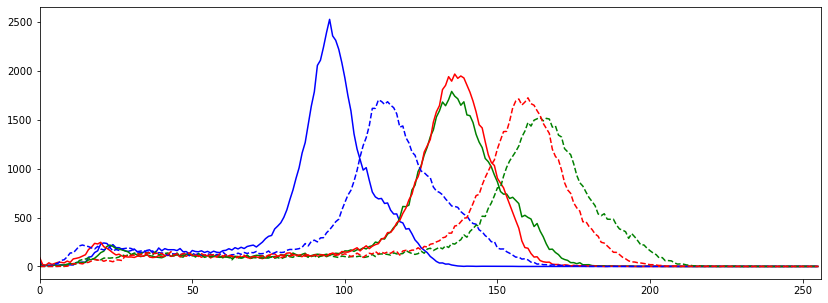

In [2]:
from tensorflow import keras
from keras.preprocessing.image import load_img,save_img
from keras.preprocessing.image import img_to_array
import numpy as np

X1=[]
pixels = load_img('C:/projets/oktal-se/testterrain.png', target_size=(256,256,3))

src = img_to_array(pixels)
X1.append(src)
X1=np.array(X1)
X1 = (X1 - 127.5) / 127.5
model = keras.models.load_model('model_001000.h5')
X = model.predict(X1)
save_img('C:/projets/oktal-se/testterrain_gan.png',X[0])
import numpy as np
import cv2 as cv
from scipy import stats
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [14, 5]
img = cv.imread('C:/projets/oktal-se/testterrain.png')
color = ('b','g','r')
print("before")
unique, counts = np.unique(img.reshape(-1, img.shape[-1]), axis=0, return_counts=True)
print("number of colors",len(counts))
for i,col in enumerate(color):
    histr = cv.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])

img1 = cv.imread('C:/projets/oktal-se/testterrain_gan.png')
print("after")
unique, counts = np.unique(img1.reshape(-1, img1.shape[-1]), axis=0, return_counts=True)
print("number of colors",len(counts))
for i,col in enumerate(color):
    histr = cv.calcHist([img1],[i],None,[256],[0,256]) 
    line=plt.plot(histr,color = col)
    plt.setp(line, linestyle='--') 
    plt.xlim([0,256])
plt.show()

before
number of colors 32


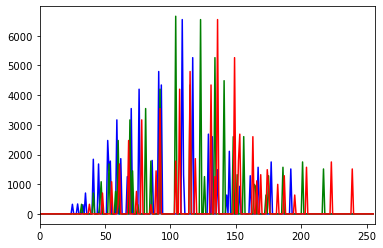

after
number of colors 39892


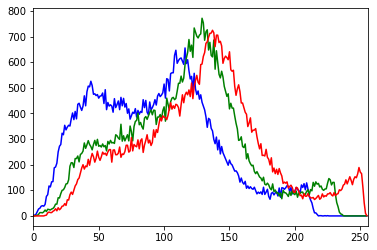

In [8]:
from tensorflow import keras
from keras.preprocessing.image import load_img,save_img
from keras.preprocessing.image import img_to_array
import numpy as np
X1=[]
pixels = load_img('C:/projets/oktal-se/img1_32_432_reduced.png', target_size=(256,256,3))
src = img_to_array(pixels)
X1.append(src)
X1=np.array(X1)
X1 = (X1 - 127.5) / 127.5
model = keras.models.load_model('model_001000.h5')
X = model.predict(X1)
save_img('C:/projets/oktal-se/img1_32_432_reduced_gan.png',X[0])
import numpy as np
import cv2 as cv
from scipy import stats
from matplotlib import pyplot as plt
img = cv.imread('C:/projets/oktal-se/img1_32_432_reduced.png')
color = ('b','g','r')
print("before")
unique, counts = np.unique(img.reshape(-1, img.shape[-1]), axis=0, return_counts=True)
print("number of colors",len(counts))
for i,col in enumerate(color):
    histr = cv.calcHist([img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()
img1 = cv.imread('C:/projets/oktal-se/img1_32_432_reduced_gan.png')
print("after")
unique, counts = np.unique(img1.reshape(-1, img1.shape[-1]), axis=0, return_counts=True)
print("number of colors",len(counts))
for i,col in enumerate(color):
    histr = cv.calcHist([img1],[i],None,[256],[0,256]) 
    plt.plot(histr,color = col)
    plt.xlim([0,256])
plt.show()

In [2]:
# example of pix2pix gan for satellite to map image-to-image translation
import numpy as np
import cv2
import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img,save_img
from keras.utils.vis_utils import plot_model
import tensorflow as tf

print(tf.config.experimental.get_memory_info("GPU:0")['current'])  # 0
# define the discriminator model
def define_discriminator(image_shape):
        # weight initialization
        init = RandomNormal(stddev=0.02)
        # source image input
        in_src_image = Input(shape=image_shape)
        # target image input
        in_target_image = Input(shape=image_shape)
        # concatenate images channel-wise
        merged = Concatenate()([in_src_image, in_target_image])
        # C64
        d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
        d = LeakyReLU(alpha=0.2)(d)
        # C128
        d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        # C256
        d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        # C512
        d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        # second last output layer
        d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        # patch output
        d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
        patch_out = Activation('sigmoid')(d)
        # define model
        model = Model([in_src_image, in_target_image], patch_out)
        # compile model
        opt = Adam(learning_rate=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
        return model

# define an encoder block
def define_encoder_block(layer_in,name, n_filters,kernel=(3,3),strides=(2,2), batchnorm=True):
        # weight initialization
        init = RandomNormal(stddev=0.02)
        # add downsampling layer
        g = Conv2D(n_filters, kernel, strides=strides, padding='same', kernel_initializer=init,name=name)(layer_in)
        # conditionally add batch normalization
        if batchnorm:
            g = BatchNormalization()(g, training=True)
        # leaky relu activation
        g = LeakyReLU(alpha=0.2)(g)
        return g

# define a decoder block
def decoder_block(layer_in, skip_in,name, n_filters,kernel=(3,3),strides=(2,2), dropout=True):
        # weight initialization
        init = RandomNormal(stddev=0.02)
        # add upsampling layer
        g = Conv2DTranspose(n_filters, kernel, strides=strides, padding='same', kernel_initializer=init,name=name)(layer_in)
        # add batch normalization
        g = BatchNormalization()(g, training=True)
        # conditionally add dropout
        if dropout:
            g = Dropout(0.5)(g, training=True)
        # merge with skip connection
        g = Concatenate()([g, skip_in])
        # relu activation
        g = Activation('relu')(g)
        return g

# define the standalone generator model
def define_generator(image_shape):
        init = RandomNormal(stddev=0.02)
        # image input
        in_image = Input(shape=image_shape)
        # encoder model
        e1 = define_encoder_block(in_image,"e1", 3, kernel=(2,2),strides=(1,1),batchnorm=False) # 64
        e2 = define_encoder_block(e1,"e2", 16,kernel=(3,3), strides=(2,2)) # 16
        e3 = define_encoder_block(e2,"e3", 128,kernel=(4,4), strides=(2,2)) # 16
        e4 = define_encoder_block(e3,"e4", 128,kernel=(4,4), strides=(2,2)) # 16
        # bottleneck, no batch norm and relu
        b = Conv2D(512, (4,4),strides=(2,2), padding='same', kernel_initializer=init,name="b")(e4)
        b = Activation('relu')(b)
        # decoder model
        d4 = decoder_block(b, e4,"d4", 512,kernel=(4,4), strides=(2,2), dropout=True)
        d5 = decoder_block(d4, e3,"d5", 512,kernel=(4,4), strides=(2,2), dropout=True)
        d6 = decoder_block(d5, e2,"d6", 128,kernel=(4,4), strides=(2,2), dropout=False)
        d7 = decoder_block(d6, e1,"d7", 16,kernel=(3,3), strides=(2,2), dropout=False)
        # output
        g = Conv2DTranspose(3, (2,2), strides=(1,1), padding='same', kernel_initializer=init)(d7)
        out_image = Activation('tanh')(g)
        # define model
        model = Model(in_image, out_image)
        opt = Adam(learning_rate=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
        #model.summary()
        return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
        # make weights in the discriminator not trainable
        for layer in d_model.layers:
            if not isinstance(layer, BatchNormalization):
                  layer.trainable = False
        # define the source image
        in_src = Input(shape=image_shape)
        # connect the source image to the generator input
        gen_out = g_model(in_src)
        # connect the source input and generator output to the discriminator input
        dis_out = d_model([in_src, gen_out])
        # src image as input, generated image and classification output
        model = Model(in_src, [dis_out, gen_out])
        # compile model
        opt = Adam(learning_rate=0.0002, beta_1=0.5)
        model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
        return model

# load and prepare training images
def load_real_samples(filename):
        # load compressed arrays
        data = load(filename)
        # unpack arrays
        X1, X2 = data['arr_0'], data['arr_1']
        return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape1,patch_shape2):
        #print("generate_real_samples",patch_shape1,patch_shape2)
        # unpack dataset
        trainA, trainB = dataset
        # choose random instances
        ix = randint(0, trainA.shape[0], n_samples)
        X1=[]
        X2=[]
        for i in ix:
            image = cv2.imread(trainA[i])
            #alpha=random.uniform(0.3, 1.1)
            #src = cv2.convertScaleAbs(image, alpha=alpha, beta=0)
            src=image
            X1.append(src)
            image = cv2.imread(trainB[i])
            #tgt = cv2.convertScaleAbs(image, alpha=alpha, beta=0)
            tgt=image
            X2.append(tgt)
        X1=np.array(X1)
        X1 = (X1 - 127.5) / 127.5
        X2=np.array(X2)
        X2 = (X2 - 127.5) / 127.5
        # generate 'real' class labels (1)
        y = ones((n_samples, patch_shape1, patch_shape2, 1))
        return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape1,patch_shape2):
    # generate fake instance
    X = g_model.predict_on_batch(samples)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape1, patch_shape2, 1))
    return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset,patch_shape1,patch_shape2, n_samples=1):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples,patch_shape1,patch_shape2)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, patch_shape1,patch_shape2)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = 255*(X_realA + 1) / 2.0
    X_realB = 255*(X_realB + 1) / 2.0
    X_fakeB = 255*(X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + i)
        pyplot.axis('off')
        img=cv2.cvtColor(X_realA[i].astype(np.uint8), cv2.COLOR_BGR2RGB)
        pyplot.imshow(img)
    # plot generated target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples + i)
        pyplot.axis('off')       
        img=cv2.cvtColor(X_fakeB[i].astype(np.uint8), cv2.COLOR_BGR2RGB)
        pyplot.imshow(img)
    # plot real target image
    for i in range(n_samples):
        pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
        pyplot.axis('off')
        img=cv2.cvtColor(X_realB[i].astype(np.uint8), cv2.COLOR_BGR2RGB)
        pyplot.imshow(img)
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    pyplot.savefig(filename1)
    pyplot.close()
    # save the generator model
    filename2 = 'g_model.h5' 
    g_model.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch1 = d_model.output_shape[1]
    n_patch2 = d_model.output_shape[2]
    print(d_model.output_shape)
    # unpack dataset
    trainA, trainB = dataset
    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    if n_steps>5000:
        n_steps=5000
    # manually enumerate epochs
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch1,n_patch2)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch1,n_patch2)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
        # summarize performance
        print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # summarize model performance
        if (i+1) % 1000 == 0:
              summarize_performance(i, g_model, dataset,n_patch1,n_patch2)
    g_model.save_weights ('C:/projets/oktal-se/g_model.h5')
    return(d_model, g_model)

# load image data
filename = 'C:/projets/oktal-se/entropy_256.npz'
dataset = load_real_samples(filename)
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
pixels = load_img(dataset[0][0])
# convert to numpy array
tgt = img_to_array(pixels)
print(tgt.shape)
image_shape = tgt.shape
# define the models
print(image_shape)
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
print(image_shape)
gan_model = define_gan(g_model, d_model, image_shape)
g_model.summary()

245595904
Loaded (4286,) (4286,)
(672, 960, 3)
(672, 960, 3)
(672, 960, 3)
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 672, 960, 3  0           []                               
                                )]                                                                
                                                                                                  
 e1 (Conv2D)                    (None, 672, 960, 3)  39          ['input_7[0][0]']                
                                                                                                  
 leaky_re_lu_17 (LeakyReLU)     (None, 672, 960, 3)  0           ['e1[0][0]']                     
                                                                                                  
 e2 (Conv2D)     